## Install and load packages and Data

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 15 20:15:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install regex tqdm ftfy

     |████████████████████████████████| 53 kB 1.4 MB/s 


In [4]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-geq44vj3
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-geq44vj3
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=447fe776558a500cf4406202443935329452cde3144008e690d75aa795a1befb
  Stored in directory: /tmp/pip-ephem-wheel-cache-lthaqpl1/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [16]:
!unzip -q Cropped\ Images.zip

In [5]:
import torch
from tqdm.notebook import tqdm
import clip
from PIL import Image
import os
import numpy
from IPython.display import Image as iImg, display

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpue"
model, transform = clip.load('ViT-B/32',device =device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 129MiB/s]


In [7]:
def get_files_with_image_endings(fp):
    img_endings = ['.png','.jpg','.jpeg']
    files = [os.path.join(fp,i) for i in os.listdir(fp) if any([i.endswith(ending) for ending in img_endings])]
    return files

In [ ]:

folder ='Cropped Images/Idiotswithguns'
images=get_files_with_image_endings(folder)

## A simple image display set up to probe CLIP

In [ ]:
caption1 = 'A photo containing a human'
caption2= 'A photo not containing a human'
def probability(caption1,caption2,images):
  captions=[caption1, caption2]
  text = clip.tokenize(captions).to(device)
  for img in images:
    image=transform(Image.open(img)).unsqueeze(0).to(device)
    with torch.no_grad():
      features = model.encode_image(image)
      text_features= model.encode_text(text)
      
     
      logits_img, logits_text = model(image,text)
      probs = logits_img.softmax(dim=-1).cpu().numpy()[0]
      display(iImg(filename=img,width = 400))
      print(f'{caption1}: {probs[0]}\n{caption2}: {probs[1]}')
probability(caption1,caption2,images[0:5])

#write program to display grid of images 




# Probing for what good captions are for each subreddit/image folder

### Functions for display

In [13]:
def compute_liklihood(caption1,caption2,img):
  captions=[caption1, caption2]
  text = clip.tokenize(captions).to(device)
  image=transform(Image.open(img)).unsqueeze(0).to(device)
  with torch.no_grad():
    features = model.encode_image(image)
    text_features= model.encode_text(text)
    logits_img, logits_text = model(image,text)
    probs = logits_img.softmax(dim=-1).cpu().numpy()[0]
    return dict(zip(captions,probs))

In [14]:
def process_images(images,caption1,caption2,prob_cutoff=0.8):
  """Returns a list of images where caption1 probability is greater than the cut off"""
  retained =[]
  for img in tqdm(images):
    p=compute_liklihood(caption1,caption2,img)
    if p[caption1]>prob_cutoff:
      retained.append(img)
  return retained

In [15]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
import numpy as np
def load_image(filename):
    return Image.open(filename).convert('RGB') #this conversion is crucial as PIL will open png files with either 3 or 4 channels depending on encoding

def load_image_numpy(filename):
    return np.asarray(load_image(filename))

def grid(imgs,nrows):
    imgs = torch.from_numpy(np.array([load_image_numpy(f) for f in imgs]))
    imgs = imgs.permute((0,3,1,2)) #reorder from bhwc to bchw
    return to_pil_image(make_grid(imgs,nrow=nrows))

def blanked_grid(imgs,keep_imgs,nrows):
    data = np.array([load_image_numpy(f) for f in imgs])
    for i in range(len(data)):
      if imgs[i] not in keep_imgs:
          data[i]=0
    imgs=torch.from_numpy(data)
    imgs = imgs.permute((0,3,1,2)) #reorder from bhwc to bchw
    return to_pil_image(make_grid(imgs,nrow=nrows))

def examine_grid(images,caption1,caption2,prob_cutoff=0.8,nrows=8,seed=42):
  """Returns 2 image grids randomly sampled from the image files. 
     2nd grid blacks out images that would be removed
  """
  size = nrows**2
  np.random.seed(seed)
  images=np.random.choice(images,size=size)
  
  g1=grid(images,nrows)
  processed=process_images(images,caption1,caption2,prob_cutoff=prob_cutoff)
  g2 = blanked_grid(images,processed,nrows)
  return g1,g2

## Investigating the appropriate captions for r/Idiotswithguns

In [ ]:
folder ='Cropped Images/Idiotswithguns'
images=get_files_with_image_endings(folder)

In [ ]:
caption1 = 'A photo containing a person'
caption2= 'A photo not containing a person'
g1,g2= examine_grid(images,caption1,caption2,nrows=8,prob_cutoff=0.66)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
g1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
g2

Output hidden; open in https://colab.research.google.com to view.

Note that different prompts change the output significantly. Experimentation is needed to determine the best prompt

In [ ]:
caption1 = 'A photo containing a person with a gun'
caption2= 'A photo not containing a person with a gun'
g1,g2_a= examine_grid(images,caption1,caption2,nrows=8,prob_cutoff=0.65)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
g1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
g2_a

Output hidden; open in https://colab.research.google.com to view.

## Optimal captions for r/TheWayWeWere

In [ ]:
folder ='Cropped Images/TheWayWeWere'
images=get_files_with_image_endings(folder)

In [ ]:
caption1 = 'A photo containing a person'
caption2= 'A photo not containing a person'
g1,g2_b= examine_grid(images,caption1,caption2,nrows=8,prob_cutoff=0.80)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
g1

Output hidden; open in https://colab.research.google.com to view.

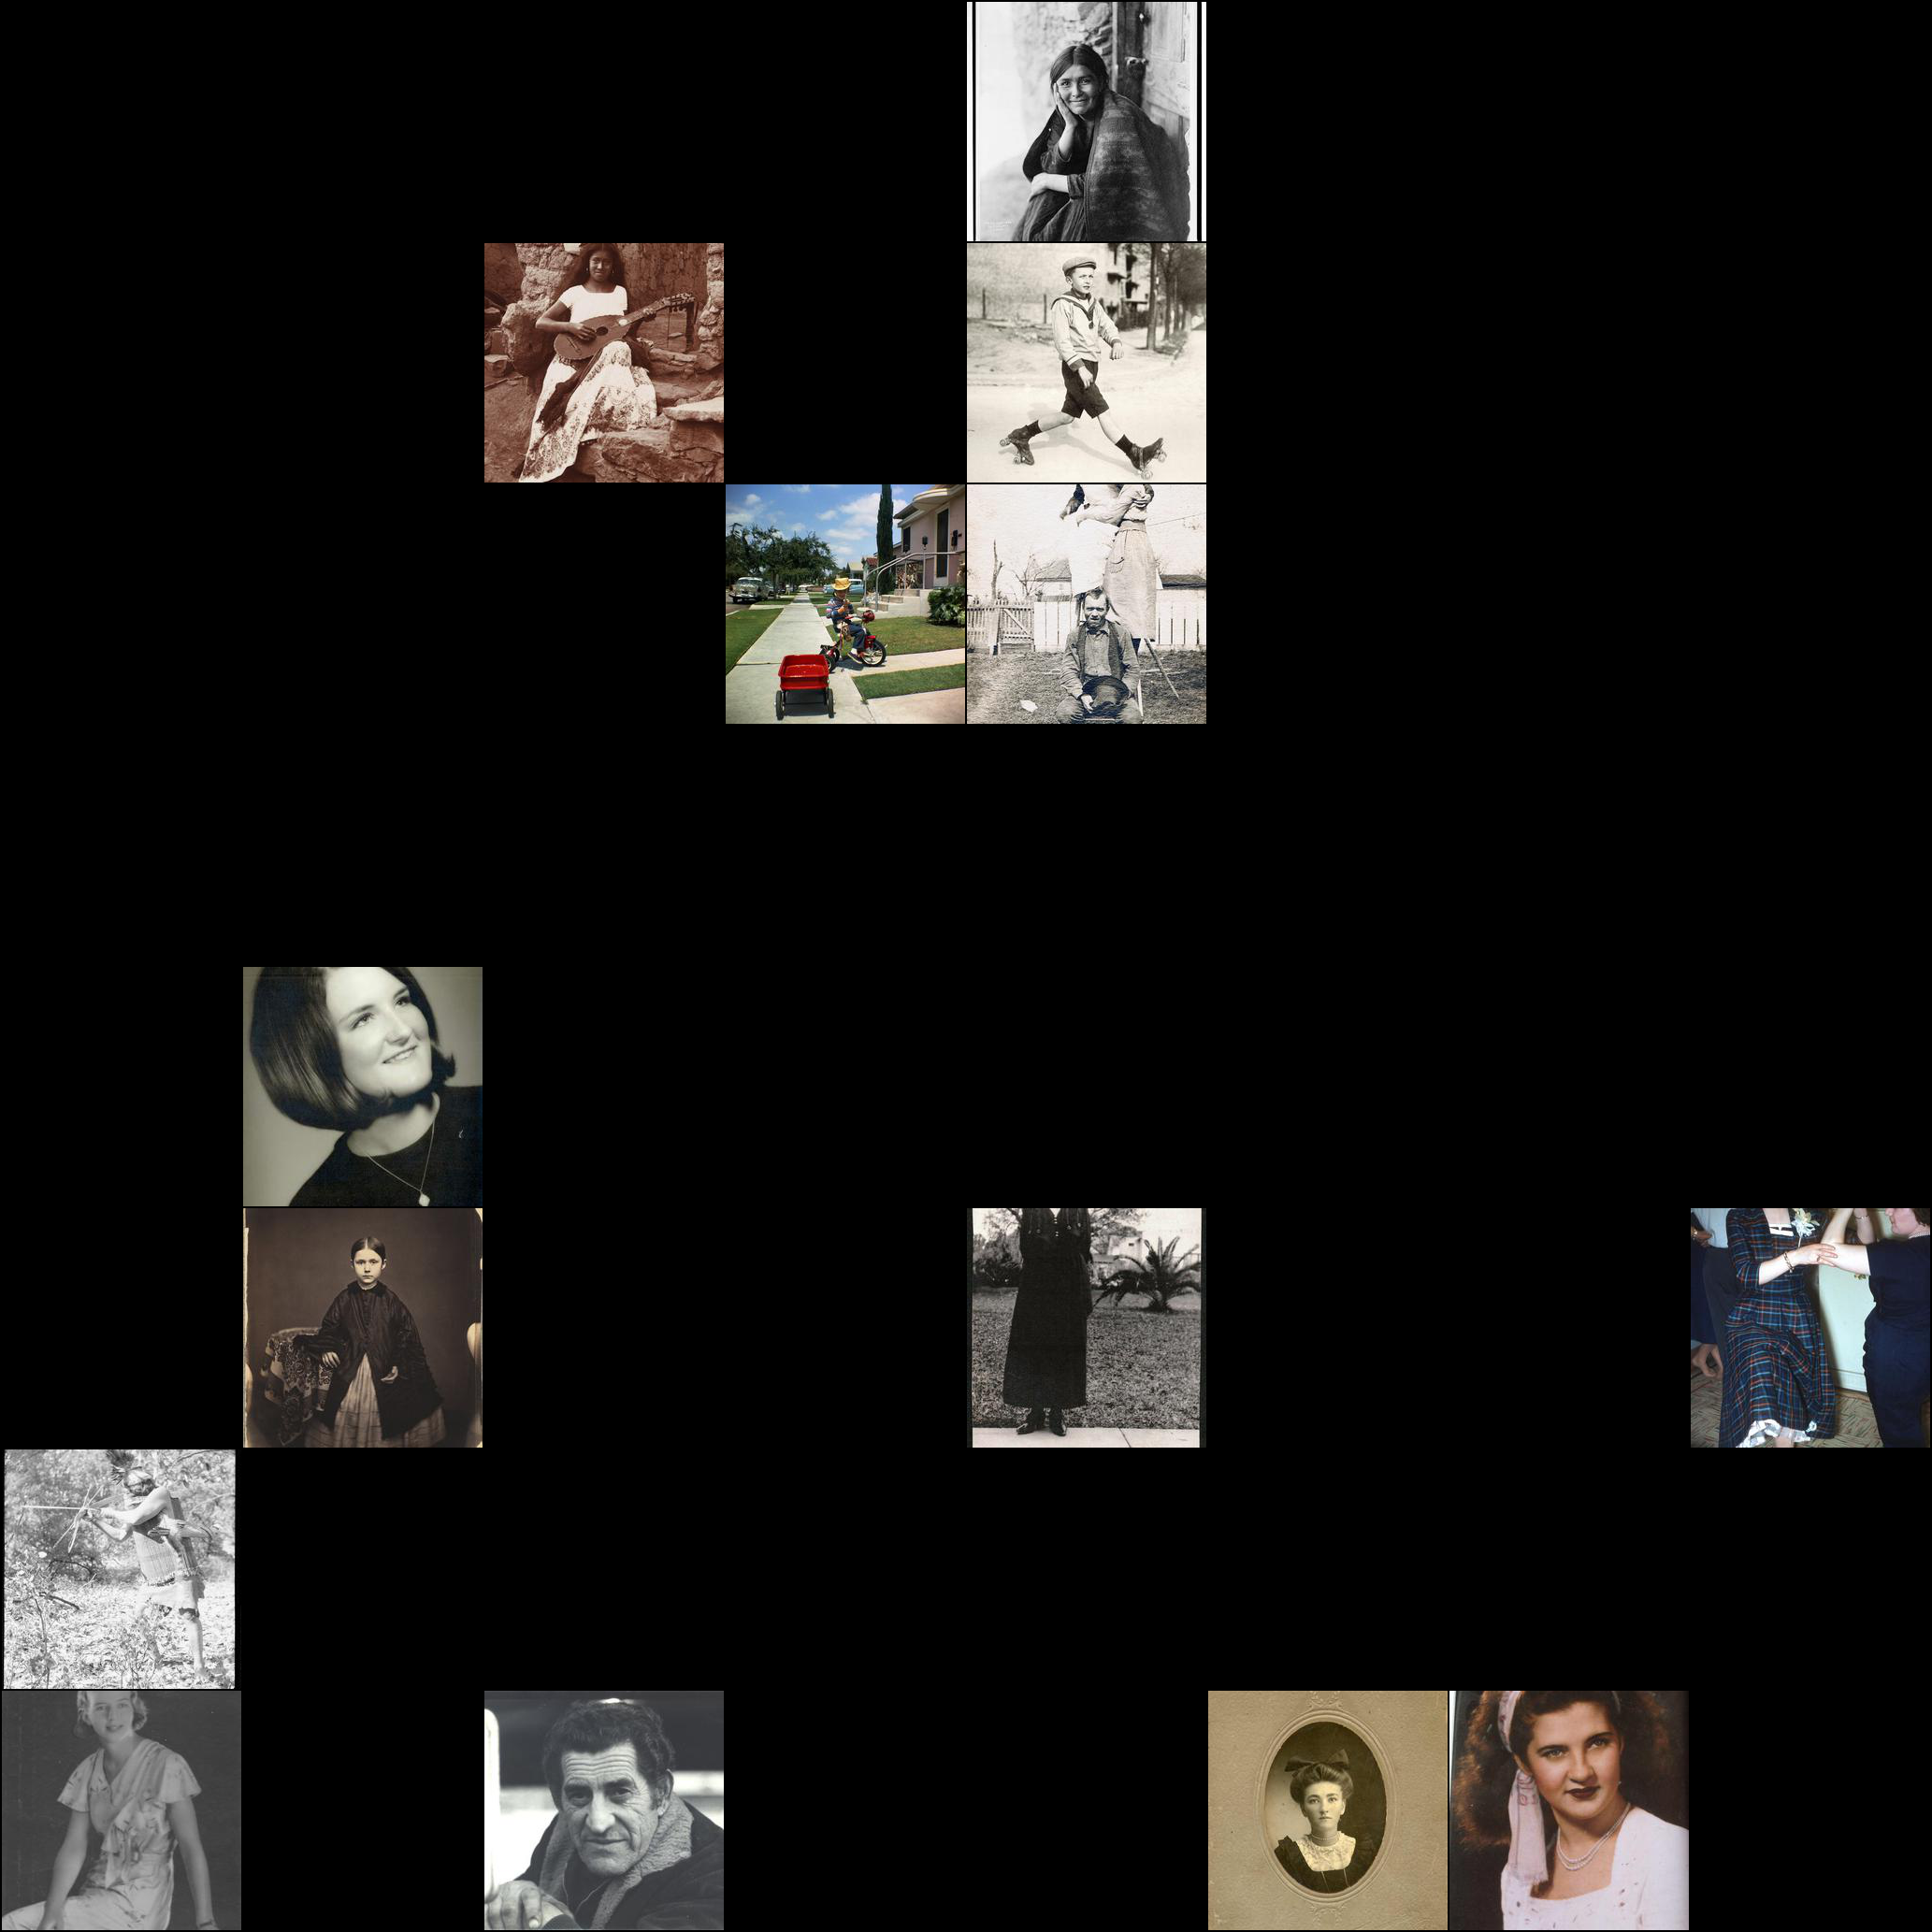

In [ ]:
g2_b

In [ ]:
folder ='Cropped Images/ChicksWithGuns'
images=get_files_with_image_endings(folder)

In [ ]:
caption1 = 'A photo containing a person with a gun'
caption2= 'A photo not containing a person with a gun'
g1,g2_c= examine_grid(images,caption1,caption2,nrows=8,prob_cutoff=0.8)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
g1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
g2_c

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
folder ='Cropped Images/portraits'
images=get_files_with_image_endings(folder)

In [ ]:
caption1 = 'A photo containing a person'
caption2= 'A photo not containing a person'
g1,g2_d= examine_grid(images,caption1,caption2,nrows=8,prob_cutoff=0.8)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
g1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
g2_d

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
folder ='Cropped Images/Weapons'
images=get_files_with_image_endings(folder)

In [ ]:
caption1 = 'A photo containing a person'
caption2= 'A photo not containing a person'
g1,g2_e= examine_grid(images,caption1,caption2,nrows=8,prob_cutoff=0.78)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
g1

Output hidden; open in https://colab.research.google.com to view.

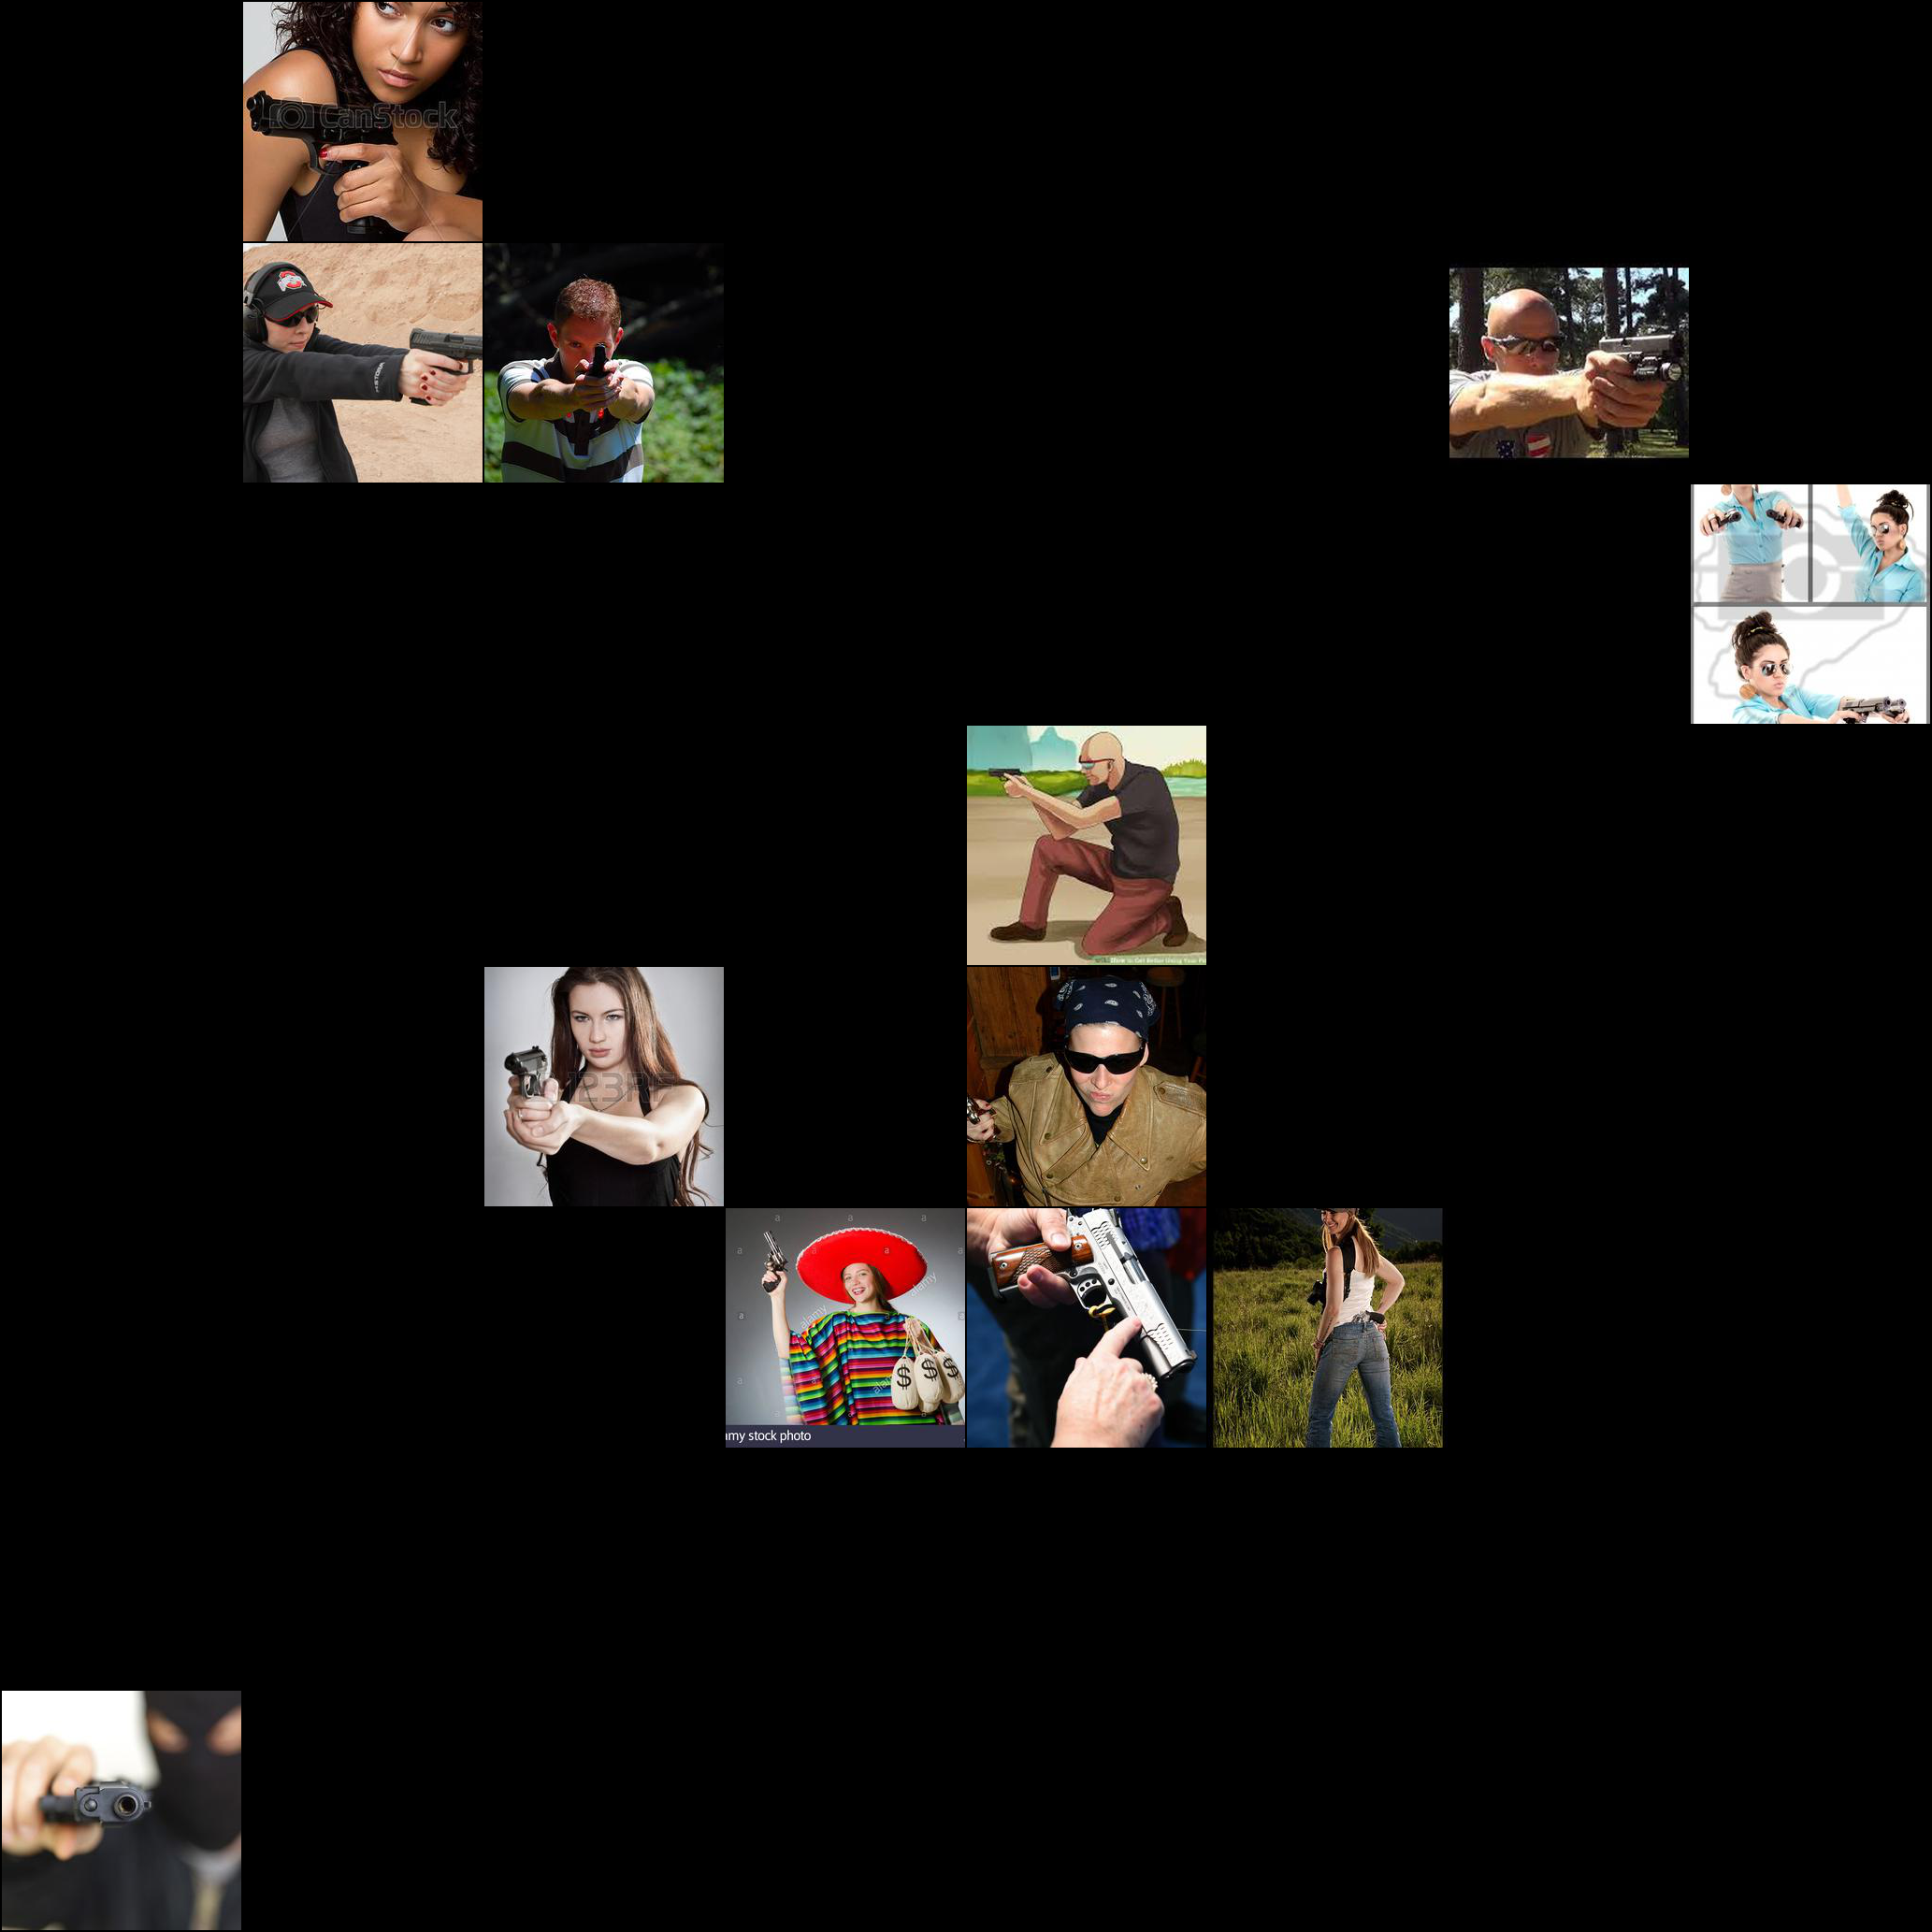

In [ ]:
g2_e

#Generating lists of final image  

In [20]:
#Dictionary of folders to search and what parameters to use for exclusion
caption_sets ={'Idiotswithguns':{'Caption 1':'A photo containing a person',
                                 'Caption 2':'A photo not containing a human',
                                 'prob_cutoff':0.66,
                                 'skip_processing':False}, 
               'TheWayWeWere':{'Caption 1': 'A photo containing a person',
                               'Caption 2': 'A photograph not containing a person',
                               'prob_cutoff':0.8, 
                               'skip_processing': False},
               'ChicksWithGuns':{'Caption 1': 'A photo containing a person with a gun',
                                 'Caption 2': 'A photo not containing a person with a gun',
                                 'prob_cutoff': 0.8,
                                 'skip_processing':False},
               'portraits':{'Caption 1': 'A photo containing a person',
                            'Caption 2': 'A photo not containing a person',
                            'prob_cutoff': 0.8,
                            'skip_processing':False},
               'Weapons':{'Caption 1': 'A photo containing a person',
                          'Caption 2': 'A photo not containing a person',
                          'prob_cutoff': 0.78,
                          'skip_processing':False},
               'guns':{'Caption 1': 'A photo containing a person',
                          'Caption 2': 'A photo not containing a person',
                          'prob_cutoff': 0.90,
                          'skip_processing':False},
               'Military':{'Caption 1': 'A photo containing a person',
                          'Caption 2': 'A photo not containing a person',
                          'prob_cutoff': 0.90,
                          'skip_processing':False},
               'pics':{'Caption 1': 'A photo containing a person holding a gun',
                          'Caption 2': 'A photo not containing a person',
                          'prob_cutoff': 0.95,
                          'skip_processing':False},
               'Weapons':{'Caption 1': 'A photo containing a person',
                          'Caption 2': 'A photo not containing a person',
                          'prob_cutoff': 0.78,
                          'skip_processing':False},
               'Shooting':{'Caption 1': 'A photo containing a person',
                          'Caption 2': 'A photo not containing a person',
                          'prob_cutoff': 0.90,
                          'skip_processing':False},
               'Guns_Guns_Guns':{'Caption 1': 'A photo containing a person',
                          'Caption 2': 'A photo not containing a person',
                          'prob_cutoff': 0.90,
                          'skip_processing':False},
               'airsoft':{'Caption 1': 'A photo containing a person',
                          'Caption 2': 'A photo not containing a person',
                          'prob_cutoff': 0.90,
                          'skip_processing':False},
               'Shotguns':{'Caption 1': 'A photo containing a person',
                          'Caption 2': 'A photo not containing a person',
                          'prob_cutoff': 0.90,
                          'skip_processing':False},
               }



In [18]:
def generate_included_csv(base_fp, caption_sets):
  maintained_images = []
  pbar =tqdm(caption_sets)
  post_fix = {'Maintained':0,'Removed':0}
  for folder in pbar :
    fp = os.path.join(base_fp,folder)
    images = get_files_with_image_endings(fp)
    if not caption_sets[folder]['skip_processing']:
      params=caption_sets[folder]
      to_add= process_images(images,params['Caption 1'],params['Caption 2'],prob_cutoff=params['prob_cutoff'])
      maintained_images+= to_add
      post_fix['Removed']+= len(images)-len(to_add)
      
    else:
      maintained_images += images
  post_fix['Maintained']= len(maintained_images)
  pbar.close()
  #write images
  with open('maintained_files.csv','w') as f:
    f.write('Maintained Filenames\n')
    f.write('\n'.join(maintained_images))
  

In [21]:
generate_included_csv('Cropped Images',caption_sets)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1505 [00:00<?, ?it/s]

  0%|          | 0/5939 [00:00<?, ?it/s]

  0%|          | 0/2827 [00:00<?, ?it/s]

  0%|          | 0/3490 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/8575 [00:00<?, ?it/s]

  0%|          | 0/3953 [00:00<?, ?it/s]

  0%|          | 0/4576 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/1433 [00:00<?, ?it/s]

  0%|          | 0/2010 [00:00<?, ?it/s]

  0%|          | 0/2631 [00:00<?, ?it/s]